In [1]:
%load_ext autoreload
%autoreload 2

# Leakage reduction in fast superconducting qubit gates via optimal control

## Introduction

Transmon qubits typically have an anharmonicity ($\eta$) of few hundreds of MHz, which helps to isolate the computational states from the higher energy states. Despite the anharmonicity, microwave pulses are tailored with Derivative Removal by Adiabatic Gate ([DRAG](https://arxiv.org/pdf/0901.0534.pdf)) technique to minimize the leakage to non-computational basis states. However, such DRAG pulses fail to produce high fidelity gates when the duration of the gate is relatively short (see Fig.3 in the paper). In order to obtain shorter gates (due to the lack of precise theoretical models), one has to rely on real-time optimization schemes. In this notebook we will showcase using QUA, the experimental protocol described in Werninghaus *et al*. The paper is included as a PDF in the current folder, or you can access it via [arXiv](https://arxiv.org/abs/2003.05952).

## Problem

The system under consideration is a single superconduting qubit (though there are actually two qubits and a flux tunable coupler in the actual experiment, but they are not used here). The Hamiltonian describing the interaction between the qubit and the microwave is given by

$$H(t) = \omega (a^{\dagger}a + \frac{1}{2}) - i  [\Omega_x(t) cos(\omega_d t + \phi) - \Omega_y(t) sin(\omega_d t + \phi)] (a - a^{\dagger}) + \frac{\Delta}{2} {a^{\dagger}}^2 a^2, $$

where $\omega / 2 \pi  = 5.11722$ GHz, the anharmonicity $\Delta / 2 \pi = −315.28$ MHz and $\omega_d = \omega + \omega_{lo}$. Here $\omega$ is the intermediate frequency that can be tuned with an OPX and $\omega_{lo}$ is the frequency of the external oscillator. By choosing pulses $\Omega_x$ and $\Omega_y$ such that the area under them is $\pi/2$ and selecting the phases $\phi = n\pi/2$ ($n=0, 1, 2, 3$) we can realize single qubit gates $\pm X/2$ and $\pm Y/2$ with the same pulse profiles.

The prescribed pulse shapes from the DRAG technique are $\Omega_x(t) = A e^{-t^2 / (2\sigma^2)}$ and $\Omega_y(t) = i\frac{\beta}{\Delta} \frac{d\Omega_x(t)}{dt}$, the amplitude $A$ and the scaling parameter $\beta$ are determined by experimental calibration. However, the gate fidelities we obtain with DRAG scheme drop when the pulse duration is smaller than $\approx 10/\Delta$. The goal is to optimize $\Omega_x(y)$ and $\Omega_y(t)$ to do short ($\tau \approx 4$ ns) Clifford gates $\pm X/2$ and $\pm Y/2$, such that the leakage is minimized. 


<center><img src="figure_1.png"/></center>

## Optimization

The authors use [CMA-ES](https://en.wikipedia.org/wiki/CMA-ES)
algorithm for the optimization of in-phase and out-of-phase components of the microwave pulse. This is a gradient-free evolutionary optimization technique, similar to the genetic algorithm. The cost function is evaluated via randomized benchmarking (RB).

<center><img src="figure_2a.png" =2x3/></center>

RB is a useful technique to estimate the fidelity of quantum operations by creating a
random circuit of Cliffords. The random circuit is followed by an operation to invert the transformation performed on the system with appropriately chosen Clifford gate to recover the initial state (as illustrated in the above figure). The final step of this procedure is a measurement which is averaged over multiple realizations, to obtain an "average" figure of merit for the fidelity of all operations performed on the qubit. A randomized benchmarking procedure script is available in the QM Libraries repo on GitHub, and is repeated here almost without changes. 

The optimization happens in two steps: 

1) the amplitudes of I-Q quadratures ($A$, $\beta$) and frequency ($\omega$) of the usual DRAG pulse are first optimized ($3$ parameters),

2) the optimal pulse obtained is then used as a starting point for another optimization step with additional degrees of freedom ($3 + 2N$ parameters, where $N$ is the number of samples). 

In the second step, corrections are added to each sample of the I-Q components of the DRAG pulse i.e.,

$$\Omega_x(n \delta t) = A e^{-n^2 \delta t^2 / (2\sigma^2)} + a_n$$

$$\Omega_y(n \delta t) = i\frac{\beta}{\Delta} \frac{d\Omega_x(n \delta t)}{dt} + b_n$$



This is referred to as a _piecewise constant pulse_ (PWC). With these added degrees of freedom, the optimization is run again to obtain the final optimized pulse. 
In the paper, during the optimization, RB is performed at a fixed depth. But once the optimization is done, the average Clifford gate fidelity is calculated by varying the circuit depth.

## QUA Implementation

The QUA program for the procedure outlined above is performed in [lr_lib](lr_lib.py). This file contains the function `get_program` which performs two operations: generation of slowly varying envelopes of I,Q needed to synthesize the waveforms and randomization of the RB circuit. 

```python
def get_program(config, params, t, N_avg, d):
    """
    A function to generate the QUA program
    :param config: the QM config dictionary
    :param params: parameter list for optimization
    :param t: duration of DRAG pulses in ns.
    :param N_avg: number of runs per RB circuit realization
    :param d: depth of the randomized circuit
    :return:
    """
    th = 0
    state, op_list = update_waveforms(params, d, config, t)
    with program() as drag_RB_prog:
        N = declare(int)
        I = declare(fixed)
        state_estimate = declare(bool)
        out_str = declare_stream()
        F = declare(fixed)
        F_str = declare_stream()
        update_frequency("qubit", params[2])
        with for_(N, 0, N < N_avg, N + 1):
            play("random_clifford_seq", "qubit")
            ## compute the recovery operation
            recovery_op = recovery_clifford(state)[0]
            if recovery_op == "I":
                wait(gauss_len, "qubit")
            else:
                play(recovery_op, "qubit")
            assign(F, get_simulated_fidelity(op_list, err=e))
            save(F, F_str)
            align("rr", "qubit")
            measure("readout", "rr", None, integration.full("integW1", I))
            assign(state_estimate, I > th)
            save(state_estimate, out_str)
            wait(500, "qubit")
        with stream_processing():
            out_str.save_all("out_stream")
            F_str.save_all("F_stream")
    return drag_RB_prog
  
```   


The QUA program generated by `get_program` is run by `get_result` which runs it multiple times to get multiple realizations at the specified RB circuit depth. The fidelity is calculated at each step and an error term is returned to be used as a cost for the next optimization step. 

```python
def get_result(prog, duration, K=10):
    """
    Upload the waveforms to the configuration and re-open the QM

    :param prog: QUA program
    :param duration: simulation duration
    :return:
    """

    QMm = QuantumMachinesManager()
    QMm.close_all_quantum_machines()
    QM = QMm.open_qm(config)
    F_avg = []
    for _ in range(K):
        job = QM.simulate(prog, SimulationConfig(duration))
        res = job.result_handles
        F = res.F_stream.fetch_all()["value"]
        F_avg.append(F.mean(axis=0))
    err = 1 - np.array(F_avg).mean()
    return err
```

(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=923589, Wed Apr  7 10:42:04 2021)
2021-04-07 10:42:04,667 - qm - INFO - Performing health check
2021-04-07 10:42:04,963 - qm - INFO - Health check passed
2021-04-07 10:42:05,309 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-07 10:42:05,643 - qm - INFO - Flags: 
2021-04-07 10:42:05,644 - qm - INFO - Simulating Qua program
2021-04-07 10:42:06,391 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-07 10:42:06,629 - qm - INFO - Flags: 
2021-04-07 10:42:06,629 - qm - INFO - Simulating Qua program
2021-04-07 10:42:07,358 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-07 10:42:07,496 - qm - INFO - Flags: 
2021-04-07 10:42:07,496 - qm - INFO - Simulating Qua program
2021-04-07 10:42:08,220 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-07 10:42:08,359 - qm - INFO - Flags: 
2021-04-07 10:42:08

2021-04-07 10:42:39,319 - qm - INFO - Simulating Qua program
2021-04-07 10:42:40,041 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-07 10:42:40,181 - qm - INFO - Flags: 
2021-04-07 10:42:40,182 - qm - INFO - Simulating Qua program
2021-04-07 10:42:40,904 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-07 10:42:41,033 - qm - INFO - Flags: 
2021-04-07 10:42:41,033 - qm - INFO - Simulating Qua program
2021-04-07 10:42:41,766 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-07 10:42:41,904 - qm - INFO - Flags: 
2021-04-07 10:42:41,905 - qm - INFO - Simulating Qua program
2021-04-07 10:42:42,731 - qm - INFO - Performing health check
2021-04-07 10:42:42,831 - qm - INFO - Health check passed
2021-04-07 10:42:43,182 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-07 10:42:43,322 - qm - INFO - Flags: 
2021-04-07 10:42:43,323 - qm - INFO - Simulating

2021-04-07 10:43:15,445 - qm - INFO - Simulating Qua program
2021-04-07 10:43:16,165 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-07 10:43:16,308 - qm - INFO - Flags: 
2021-04-07 10:43:16,309 - qm - INFO - Simulating Qua program
2021-04-07 10:43:17,058 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-07 10:43:17,188 - qm - INFO - Flags: 
2021-04-07 10:43:17,188 - qm - INFO - Simulating Qua program
2021-04-07 10:43:17,913 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-07 10:43:18,040 - qm - INFO - Flags: 
2021-04-07 10:43:18,041 - qm - INFO - Simulating Qua program
2021-04-07 10:43:18,799 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-07 10:43:18,928 - qm - INFO - Flags: 
2021-04-07 10:43:18,928 - qm - INFO - Simulating Qua program
2021-04-07 10:43:19,648 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-0

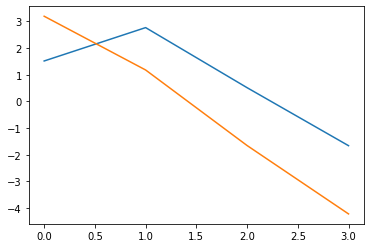

In [2]:
# !pip install cma
# !pip install http::IP/python-package ## ask for the IP address

import cma
from lr_lib import *
import numpy as np
import matplotlib.pyplot as plt
import time


##we first optimize a regular DRAG pulse
np.random.seed(3)
es1 = cma.CMAEvolutionStrategy(np.random.rand(3), 0.5)
es1.optimize(cost_DRAG, iterations=1)
es1.result_pretty()

##Finally, we use the optimized DRAG pulse to add more degrees of freedom
## use A, B, freq as initial guess for the full optimization
start = time.time()
init = list(es1.result.xbest) + list(np.random.rand(n_params))
sigma0 = 0.5
es2 = cma.CMAEvolutionStrategy(init, sigma0, {"popsize": 2})
es2.optimize(cost_optimal_pulse, iterations=1)
es2.result_pretty()
end = time.time()
print(end - start)


# We can now draw the optimal pulse
#NOTE: the figure displayed at the end is only for illustration

opt_pulse = np.array(get_DRAG_pulse("X/2", es2.result.xbest, pulse_duration))
plt.plot(opt_pulse[0, :])
plt.plot(opt_pulse[1, :])